# 군집화


## K-평균 알고리즘

임의의 지점을 선택해 해당 중심에 가장 가까운 포인트를 선택하여 클러스터를 정하는 군집화 기법

In [1]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
iris = load_iris()
# 보다 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=['sepal_length','sepal_width','petal_length','petal_width'])
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [3]:
# init = 초기 센트로이드 좌표 설정 방식

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(irisDF)

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, random_state=0)

In [4]:
# 군집화 수행 결과 각 데이터가 어떤 중심에 속하는지 확인

print(kmeans.labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


In [5]:
irisDF['target'] = iris.target
irisDF['cluster']=kmeans.labels_
iris_result = irisDF.groupby(['target','cluster'])['sepal_length'].count()
print(iris_result)

target  cluster
0       1          50
1       0          48
        2           2
2       0          14
        2          36
Name: sepal_length, dtype: int64


# 군집화 시각화

피처를 2개로 줄여 2차원에 시각화

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(iris.data)

irisDF['pca_x'] = pca_transformed[:,0]
irisDF['pca_y'] = pca_transformed[:,1]
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target,cluster,pca_x,pca_y
0,5.1,3.5,1.4,0.2,0,1,-2.684126,0.319397
1,4.9,3.0,1.4,0.2,0,1,-2.714142,-0.177001
2,4.7,3.2,1.3,0.2,0,1,-2.888991,-0.144949


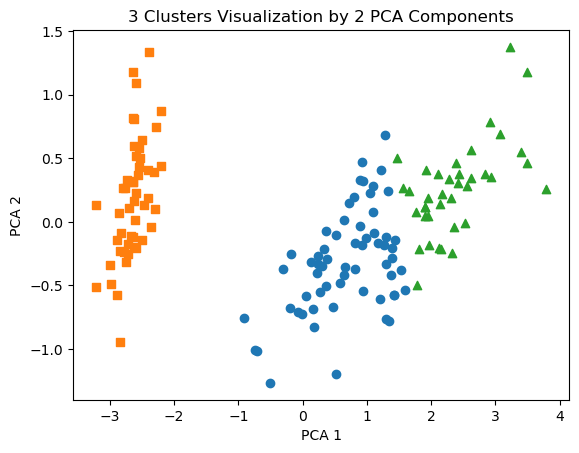

In [7]:
# 군집 값이 0, 1, 2인 경우마다 별도의 인덱스로 추출
marker0_ind = irisDF[irisDF['cluster']==0].index
marker1_ind = irisDF[irisDF['cluster']==1].index
marker2_ind = irisDF[irisDF['cluster']==2].index

# 군집 값 0, 1, 2에 해당하는 인덱스로 각 군집 레벨의 pca_x, pca_y 값 추출. o, s, ^ 로 마커 표시
plt.scatter(x=irisDF.loc[marker0_ind, 'pca_x'], y=irisDF.loc[marker0_ind, 'pca_y'], marker='o')
plt.scatter(x=irisDF.loc[marker1_ind, 'pca_x'], y=irisDF.loc[marker1_ind, 'pca_y'], marker='s')
plt.scatter(x=irisDF.loc[marker2_ind, 'pca_x'], y=irisDF.loc[marker2_ind, 'pca_y'], marker='^')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

# 군집 평가(Cluster Evaluation)

위에 경우 붓꽃 데이터의 타겟 레이블이 가지고 있어 군집화를 평가할 수 있었다. 

* `실루엣분석`

각 군집 간 거리가 얼마나 효유적으로 분리되어 있는지 나타냄. 동일 군집내 거리는 가깝고 다른 군집과의 거리는 떨어져있는 정도를 판단함.

이 정도를 나타내는게 실루엣 계수 기반 판단하며 -1~1까지의 값.1에 가까울수록 근처 군집과 더 떨어져있고 0에 가까울수록 근처군집과 가까워진다. 


* 좋은 군집화의 조건

1. 전체 실루엣 계수 평균값(silhouette_score())값이 0~1 사이이며 1에 가까울 수록 좋다.

2. 더불어 개별 군집의 평균값의 편차가 크지 않아야한다.(동일 군집내 값들이 거리가 가깝다)



In [9]:
# 실루엣 분석 metric 값을 구하기 위한 API 추가
from sklearn.metrics import silhouette_samples, silhouette_score

# iris 의 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(iris.data, irisDF['cluster'])
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

# irisDF에 실루엣 계수 컬럼 추가
irisDF['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(iris.data, irisDF['cluster'])
print('붓꽃 데이터셋 Silhouette Analysis Score:{0:.3f}'.format(average_score))

silhouette_samples( ) return 값의 shape (150,)
붓꽃 데이터셋 Silhouette Analysis Score:0.553


,sepal_length,sepal_width,petal_length,petal_width,target,cluster,pca_x,pca_y,silhouette_coeff
0,5.1,3.5,1.4,0.2,0,1,-2.684126,0.319397,0.852955
1,4.9,3.0,1.4,0.2,0,1,-2.714142,-0.177001,0.815495
2,4.7,3.2,1.3,0.2,0,1,-2.888991,-0.144949,0.829315


In [12]:
# 각 군집의 실루엣계수의 평균

irisDF.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.417320
1    0.798140
2    0.451105
Name: silhouette_coeff, dtype: float64

# 클러스터별 평균 실루엣 계수의 시각화를 통한 클러스터 개수 최적화 방법

In [13]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성

def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting t

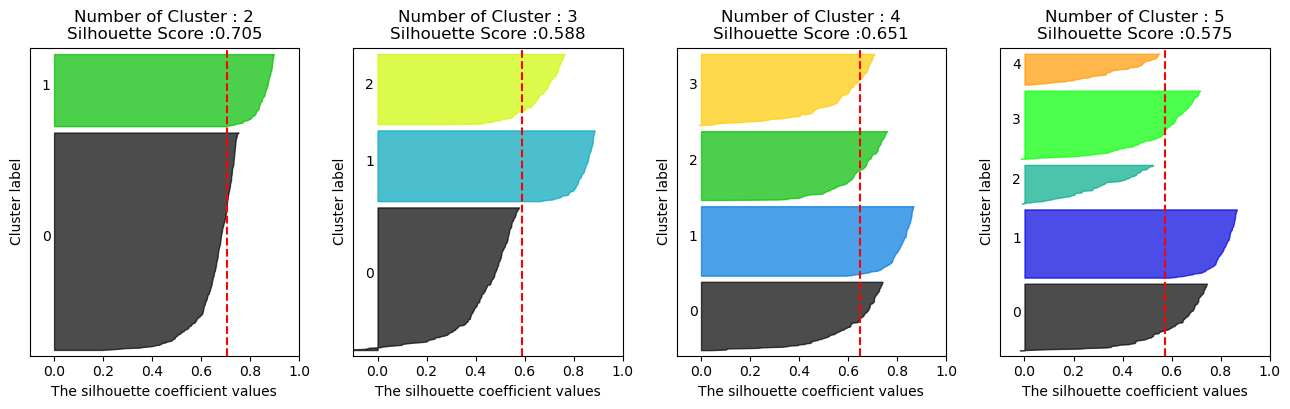

In [14]:
# make_blobs 을 통해 clustering 을 위한 4개의 클러스터 중심의 500개 2차원 데이터 셋 생성 


from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, \
                  center_box=(-10.0, 10.0), shuffle=True, random_state=1)  

# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([ 2, 3, 4, 5], X)

다음을 살펴보면 군집 개수(number of cluster)의 개수가 2일때 실루엣 계수가 0.704로 매우 높게 나온다. 하지만 이렇게 2개로 군집화하는 것이 최적의 방법일까? 붉은 점선은 평균 실루엣 계수 값. 2번 군집(검정)의 경우 이 평균보다 적은 데이터값이 매우 많다.

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting t

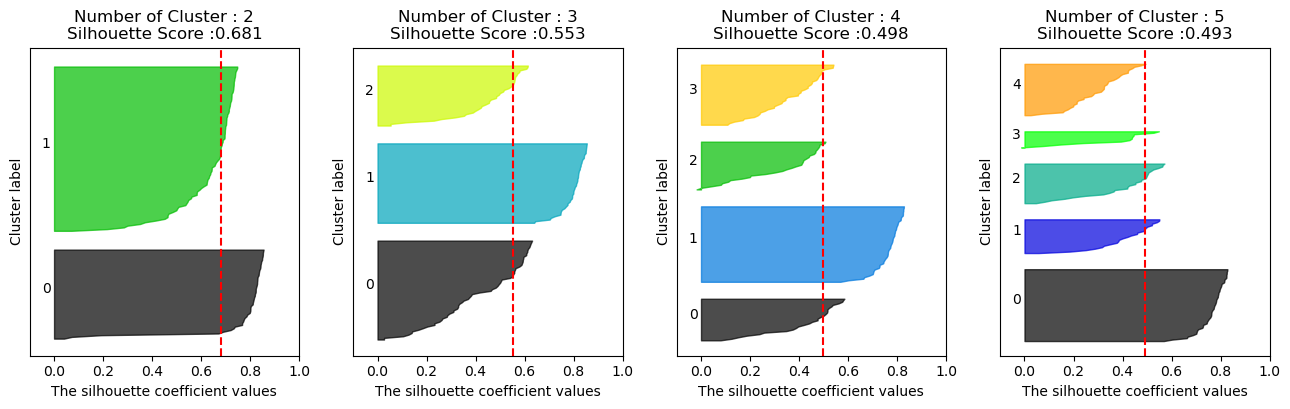

In [15]:
from sklearn.datasets import load_iris

iris=load_iris()
visualize_silhouette([ 2, 3, 4,5 ], iris.data)

붓꽃 데이터의 경우 군집 개수를 2개로 하는 것이 최적으로 판단된다. 3개의 경우 실루엣계수값도 2개일때보다 작을뿐더러 군집간의 계수 편차가 크다. 이는 개수가 4개일때와 5개일때도 마찬가지이다.